In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

# 1. Basic Dynamic Programming

In [182]:
%time
def EditDistDP(A,B):
    """
    Minimum Edit Distance ( Classical Algorithm/ Dynamic Programming )
    A ----> Initial State
    B ----> Goal State
    So we are transforming A --> B
    
    In the analysis.ipynb the algorithm is renamed as ed_dp
    """
    m=len(A)
    n=len(B)
    c=np.zeros(shape=(m+1,n+1))
    d=[[None for i in range(n+1)] for i in range(m+1)]
    count=0
    for i in range(m+1):
        count+=1
        c[i,0]=i
        if i==0:
            d[0][0]='0'
        else:
            d[i][0]=A[i-1]
    for i in range(1,n+1):
        count+=1
        c[0,i]=i
        d[0][i]=B[i-1]
    
    for i in range(1,m+1):
        for j in range(1,n+1):
            count+=1
            k=min([c[i-1,j-1],c[i-1,j],c[i,j-1]])
            if k==c[i-1][j]:
                d[i][j]="^"
            elif k==c[i][j-1]:
                d[i][j]="<"
            else:
                d[i][j]="`"
            
            
            if A[i-1]==B[j-1]:
                c[i][j]=c[i-1][j-1]
                d[i][j]="`"
            else:
                c[i][j]=k+1
                if k==c[i-1][j-1]:
                    d[i][j]="s"
    #print(f"No of Changes {c[-1][-1]} \nCells calculated:",count,'\n')
    #get_alignment(A,B,d)
    return c[-1][-1],count

def get_alignment(A,B,d):
    m=len(d)
    n=len(d[0])-1
    i=m-1
    ed=0
    print(f"Transforming {A} in {B}")
    while i>0 and n>0:
        if d[i][n]=='s':
            print(f'Subsititute {A[i-1],i-1} with {B[n-1]}')
            n-=1
            i-=1
        elif d[i][n]=='^':
            print(f'Delete {A[i-1],i-1}')
            i-=1
        elif d[i][n]=="<":
            try:
                print(f'Add {B[n-1]} between {A[i-1],i-1} and {A[i],i}')
            except:
                print(f'Add {B[n-1]} after {A[i-1],i-1}')
            n-=1
        elif d[i][n]=='`':
            n-=1
            i-=1
    if n>0:
        print('Add',B[:n])
    if i>0:
        print('Delete',A[:i])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [156]:
EditDistDP('ggct','ccga')

No of Changes 4.0 
Cells calculated: 25 

Transforming ggct in ccga
Subsititute ('t', 3) with a
Subsititute ('c', 2) with g
Subsititute ('g', 1) with c
Subsititute ('g', 0) with c


(4.0,
 25,
 None,
 array([[0., 1., 2., 3., 4.],
        [1., 1., 2., 2., 3.],
        [2., 2., 2., 2., 3.],
        [3., 2., 2., 3., 3.],
        [4., 3., 3., 3., 4.]]))

# 2. Dynamic Algorithm with Adjustable Cell Operations

In [183]:
def EditDistDp_AdDiag(A,B,t=None):
    """
    Minimum Edit Distance ( Classical Algorithm/ Dynamic Programming ) with adjustable restrcited cell operations
    A ----> Initial State
    B ----> Goal State
    So we are transforming A --> B
    
    Ref:https://www.youtube.com/watch?v=7GCSA4u5ynw
    Practical Methods for Approximate String Matching by Heikki Hyyrö 
    
    In the analysis.ipynb the algorithm is renamed as ed_dp_diagonal
    """
    m=len(A)
    n=len(B)
    if n<m:
        A,B=B,A
        m,n=len(A),len(B)
        
    
    c=-1*np.ones(shape=(m+1,n+1))
    d=[[None for i in range(n+1)] for i in range(m+1)]
    if not t:
        t=abs(m-n)+1
    threshold=np.ceil((t-abs(n-m))/2)
    count=0
    for i in range(m+1):
        if i<=threshold:
            count+=1
            c[i][0]=i
        if i==0:
            d[0][0]='0'
        else:
            d[i][0]=A[i-1]
    for i in range(1,n+1):
        if i<=threshold:
            count+=1
            c[0][i]=i
        d[0][i]=B[i-1]
    
    for i in range(1,m+1):
        for j in range(1,n+1):
            if abs(i-j)<=threshold:
                count+=1
                minimum,k=find_min(c,(i-1,j-1),(i-1,j),(i,j-1),threshold)
                if k==(i-1,j):
                    d[i][j]="^"
                elif k==(i,j-1):
                    d[i][j]="<"
                else:
                    d[i][j]="`"
                    
                
                if A[i-1]==B[j-1]:
                    c[i][j]=c[i-1][j-1]
                    d[i][j]="`"

                else:
                    c[i][j]=minimum+1
                    if k==(i-1,j-1):
                        d[i][j]="s"
    # Update t if necessary
    if c[m][n]<0:
        k2=n
        d[m][n]="<"
        while c[m][k2]<0:
            k2-=1
            d[m][k2]="<"
        c[m][n]=c[m][k2]+n-k2
        
    if c[m][n]>t:
        return EditDistDp_AdDiag(A,B,2*t)
    
    #print("Total cells calculated: ",count,'\n')
    #print("Edit Distance Operations",c[-1][-1],'\n')
    #get_alignment_restriction(A,B,d)
    return c[-1][-1],count

def find_min(c,x,y,z,threshold):
    minimum=max(c[x],c[y],c[z])
    index=0
    for i in [x,y,z]:
        if minimum >=c[i] and c[i]>=0:
            minimum=c[i]
            index=i
        elif minimum>=c[i] and i[0]==i[1]:
            minimum=c[i]
            index=i
    return minimum,index


def get_alignment_restriction(A,B,d):
    m=len(d)
    n=len(d[0])-1
    i=m-1
    print(f"Transforming {A} into {B} \n")
    while i>0 and n>0:
        if d[i][n]=='s':
            print(f'Subsititute {A[i-1],i-1} with {B[n-1]}')
            n-=1
            i-=1
        elif d[i][n]=='^':
            print(f'Delete {A[i-1],i-1}')
            i-=1
        elif d[i][n]=="<":
            try:
                print(f'Add {B[n-1]} between {A[i-1],i-1} and {A[i],i}')
            except:
                print(f'Add {B[n-1]} after {A[i-1],i-1}')
            n-=1
        elif d[i][n]=='`':
            n-=1
            i-=1
    if n>0:
        print('Add',B[:n])
    if i>0:
        print('Delete',A[:i])

In [158]:
EditDistDp_AdDiag('abcde','bade')

Total cells calculated:  14 

Edit Distance Operations 2.0 

Transforming bade into abcde 

Subsititute ('a', 1) with c
Add a


array([[ 0.,  1., -1., -1., -1., -1.],
       [ 1.,  1.,  1., -1., -1., -1.],
       [-1.,  1.,  2.,  2., -1., -1.],
       [-1., -1.,  2.,  3.,  2., -1.],
       [-1., -1., -1.,  3.,  3.,  2.]])

# 3. Diagonal Restriction where a stripe of size k around the diagonal of the matrix is filled

In [159]:
def EditDistDp_KDiag(A,B,k):
    """
    Minimum Edit Distance ( Classical Algorithm/ Dynamic Programming ) with restrcited cell operations part 2
    A ----> Initial State
    B ----> Goal State
    k ----> Band Value
    So we are transforming A --> B
    
    
    Ref:https://www.youtube.com/watch?v=7GCSA4u5ynw
    Practical Methods for Approximate String Matching by Heikki Hyyrö 
    
    In analysis.ipynb this algorithm is renamed as ed_dp_restricted_cells
    """
    m=len(A)
    n=len(B)
    if m>n:
        min_str=B
        max_str=A
    else:
        min_str=A
        max_str=B
    m=len(min_str)
    n=len(max_str)
        
    if m==1:
        if min_str[0] in max_str:
            return len(max_str)-1
        return len(max_str)
        
    
    
    c=-10*np.ones(shape=(m+1,n+1))
    d=[[None for i in range(n+1)] for i in range(m+1)]
    count=0
    for i in range(m+1):
        if i<=k-1:
            count+=1
            c[i][0]=i
        if i==0:
            d[0][0]='0'
        else:
            d[i][0]=min_str[i-1]
    for i in range(1,n+1):
        if i<=k-1:
            count+=1
            c[0][i]=i
        d[0][i]=max_str[i-1]
    threshold=k//2
    for i in range(1,m+1):
        for j in range(1,n+1):
            if abs(i-j)<=threshold:
                count+=1
                minimum,index=find_min(c,(i-1,j-1),(i-1,j),(i,j-1),0)
                if index==(i-1,j):
                    d[i][j]="^"
                elif index==(i,j-1):
                    d[i][j]="<"
                else:
                    d[i][j]="`"


                if min_str[i-1]==max_str[j-1]:
                    c[i][j]=c[i-1][j-1]
                    d[i][j]="`"

                else:
                    c[i][j]=minimum+1
                    if index==(i-1,j-1):
                        d[i][j]="s"
    if c[m][n]<0:
        k2=n
        d[m][n]="<"
        while c[m][k2]<0:
            k2-=1
            d[m][k2]="<"
        c[m][n]=c[m][k2]+n-k2
    
    print("Total cells calculated: ",count,"\n")
    print("Edit Distance Operations",c[-1][-1],"\n")
    return c[-1][-1],count,get_alignment(min_str,max_str,d)

def find_min(c,x,y,z,threshold):
    minimum=max(c[x],c[y],c[z])
    index=0
    for i in [x,y,z]:
        if c[i]>=threshold:
            if minimum >=c[i] and c[i]>=0:
                minimum=c[i]
                index=i
            elif minimum>=c[i] and i[0]==i[1]:
                minimum=c[i]
                index=i
    minimum=max(0,minimum)
    return minimum,index

In [160]:
EditDistDp_KDiag('abcde','abgd',3)

Total cells calculated:  16 

Edit Distance Operations 2.0 

Transforming abgd in abcde
Add e after ('d', 3)
Subsititute ('g', 2) with c


(2.0, 16, None)

# 4. Dynamic Programming Divide and Conquer

In [175]:
def ed_dp_linear(A,B):
    m=len(A)
    n=len(B)
    L=np.zeros(shape=(m+1,2))
    
    for i in range(m+1):
        L[i][0]=i
    for i in range(n):
        L[0,1]=L[0,0]+1
        for j in range(1,m+1):
            if B[i]==A[j-1]:
                L[j,1]=L[j-1][0]
            else:
                L[j,1]=min(L[j-1][0],L[j][0],L[j-1][1])+1
        if i<n-1:
            L[:,0]=L[:,1]
    return L[:,1][1:]

def backward_ed_dp_linear(A,B):
    m=len(A)
    n=len(B)
    L=np.zeros(shape=(m+1,2))
    
    for i in range(m,-1,-1):
        L[i][1]=m-i
        
    for j in range(n-1,-1,-1):
        L[-1,0]=L[-1,1]+1
        for i in range(m-1,-1,-1):
            if A[i]==B[j]:
                L[i,0]=L[i+1][1]
            else:
                L[i,0]=min(L[i+1][1],L[i][1],L[i+1][0])+1
        if j>0:
            L[:,1]=L[:,0]
    return L[:,0][:-1]

P=[]
def EdDp_DivCon(A,B,add1,add2):
    """In the analysis.ipynb the algorithm is renamed as divide_conquer_ed_dp"""
    global P
    m,n=len(A),len(B)
    if m<=2 or n<=2:
        c=np.zeros(shape=(m+1,n+1))
        d=[[None for i in range(n+1)] for j in range(m+1)]
        for i in range(m+1):
            c[i,0]=i
        for j in range(n+1):
            c[0,j]=j
        for i in range(1,m+1):
            for j in range(1,n+1):
                k=min([c[i-1,j-1],c[i-1,j],c[i,j-1]])
                if k==c[i-1][j]:
                    d[i][j]=[i-1,j]
                elif k==c[i][j-1]:
                    d[i][j]=[i,j-1]
                else:
                    d[i][j]=[i-1,j-1]
                    
                if A[i-1]==B[j-1]:
                    c[i][j]=c[i-1][j-1]
                    d[i][j]=[i-1,j-1]
                
                else:
                    c[i][j]=k+1
                    if k==c[i-1][j-1]:
                        d[i][j]=[i-1,j-1]
                    
        x1=m
        x2=n
        if [x1+add1,x2+add2] not in P:
            P.append([x1+add1,x2+add2])
            
        while x1>0 and x2>0 and d[x1][x2]!=[0,0]:
            if [d[x1][x2][0]+add1,d[x1][x2][1]+add2] not in P:
                P.append([d[x1][x2][0]+add1,d[x1][x2][1]+add2])
            x1,x2=d[x1][x2]
        
    else:
        L1=ed_dp_linear(A,B[:n//2])
        L2=backward_ed_dp_linear(A,B[n//2:])
        q=find_max(L1,L2)[0]
        #print(q,n//2)
        
        if [q+add1+1,n//2+add2+1] not in P:
            P.append([q+add1+1,n//2+add2+1])
        EdDp_DivCon(A[:q+1],B[:n//2+1],add1,add2)
        EdDp_DivCon(A[q:],B[n//2:],q+add1,n//2+add2)
        
def find_max(x,y):
    minimum=max(x)+max(y)
    index=0
    for i in range(len(x)):
        if minimum>=x[i]+y[i]:
            index=i
            minimum=x[i]+y[i]
    return index,minimum

def CreateAlignmentMat(A,B,P):
    m,n=len(A),len(B)
    S=[[None for i in range(n+1)] for i in range(m+1)]
    S[0][0]="chosen"
    for cell in P:
        S[cell[0]][cell[1]]="chosen"
    i,j=m,n
    while i>0 or j>0:
        if S[i-1][j-1]=="chosen":
            if A[i-1]==B[j-1]:
                S[i][j]="`"
            else:
                S[i][j]="s"
            i-=1
            j-=1
        elif S[i-1][j]=="chosen":
            S[i][j]="^"
            i-=1
        else:
            S[i][j]='<'
            j-=1
    get_alignment(A,B,S)
    return S

In [176]:
# Run the divide and conquer algorithm for getting P which contains the cell location
EdDp_DivCon('ggde','ddeg',0,0)

In [177]:
# For alignment
CreateAlignmentMat('ggde','ddeg',P)

Transforming ggde in ddeg
Add g after ('e', 3)
Subsititute ('g', 1) with d
Delete g


[['chosen', None, None, None, None],
 ['^', None, None, None, None],
 [None, 's', None, None, None],
 [None, None, '`', None, None],
 [None, None, None, '`', '<']]

# 5. Recursion

In [173]:
def ed_recursion(str1, str2, m, n):
 
    
    if m == 0:
        return n
 
    
    if n == 0:
        return m
 
    
    if str1[m-1] == str2[n-1]:
        return ed_recursion(str1, str2, m-1, n-1)
 

    return 1 + min(ed_recursion(str1, str2, m, n-1),    # Insert
                   ed_recursion(str1, str2, m-1, n),    # Remove
                   ed_recursion(str1, str2, m-1, n-1)    # Replace
                   )

# 6. Branch and Bound

In [ ]:
import string

def bbound(s1, s2, cost=0, bound=0):
    n = len(s1) 
    m = len(s2) 

    if n == 0 and m == 0:
        return 0, [], []

    if n == 0:
        return m, ["_" for i in range(m)], [s2[i] for i in range(m)]

    if m == 0:
        return n, [s1[i] for i in range(n)], ["_" for i in range(n)]

    
    weightx = abs((n - 1) - m)
    weighty = weightx + cost
    
    weightp = abs(n - (m - 1))
    weightq = weightp + cost

    
    weightw = abs((n - 1) - (m - 1))
    if s1[-1] == s2[-1]:
        weightm = weightw + cost - 1
    else:
        weightm = weightw + cost
    ad1, ad2, ai1, ai2, ac1, ac2 = [], [], [], [], [], []

    
    if bound >= weighty:
        # Deletion branch for the algo
        deletion,ad1,ad2  = bbound(s1[:-1], s2, cost + 1, bound)  # Deletion
        deletion += 1
    else:
        deletion = 500

    
    if bound >= weightq:
        #Insertion branch for algo
        insertion,ai1,ai2 = bbound(s1, s2[:-1], cost + 1, bound)  # Insertion
        insertion += 1
    else:
        insertion = 500
    if bound >= weightw:
        #3 branch compare the last two protein strings
        if (s1[-1] != s2[-1]):
            substitution,ac1,ac2 = bbound(s1[:-1], s2[:-1], cost + 1, bound)
            substitution += 1
        else:
            substitution,ac1,ac2 = bbound(s1[:-1], s2[:-1], cost, bound)
    else:
        substitution = 500

    
    values = [deletion, insertion, substitution]
    minval = min(deletion, insertion, substitution)
    if values.index(minval) == 0:
        ad1 = ad1 + [s1[-1]]
        ad2 = ad2 + ["_"]
        return minval, ad1, ad2
    elif values.index(minval) == 1:
        ai1 = ai1 + ["_"]
        ai2 = ai2 +[s2[-1]]
        return minval, ai1, ai2
    else:
        ac1 = ac1 + [s1[-1]]
        ac2 = ac2 + [s2[-1]]
        return minval, ac1, ac2

def operations(al1, al2):
    
    n = len(al1)
    for i in range(n):
        if al1[i] == "_":
            print("Deletion at index " + str(i))
        elif al2[i]== "_":
            print("Insertion " + al1[i] + " at index " + str(i))
        elif al1[i] != al2[i]:
            print("Substitution " + al1[i] + " for " + al2[i] + " at index " + str(i))

# 7. Greedy Method

In [169]:
def greedy(A,B):
    m=len(A)
    n=len(B)
    i,j=0,0
    print("Transforming A to B")
    distance=0
    while i<m and j<n:
        if A[i]!=B[j]:
            distance+=1
            print(f"Replace {A[i],i} with {B[j]}")
        i+=1
        j+=1
    if i!=m:
        print(f"Delete {A[i:]}")
    if j!=n:
        print(f"Add {B[j:]}")
    print("Number of operations",distance+m-i+n-j)
    #return distance+m-i+n-j

In [170]:
greedy('aaaa','bbbb')

Transforming A to B
Replace ('a', 0) with b
Replace ('a', 1) with b
Replace ('a', 2) with b
Replace ('a', 3) with b
Number of operations 4


In [171]:
greedy('aa','babb')

Transforming A to B
Replace ('a', 0) with b
Add bb
Number of operations 3


In [172]:
greedy('abc','abcde')

Transforming A to B
Add de
Number of operations 2


# Experiment with Artificial Data and Protein Dataset is done in the analysis.ipynb file
 Below is a small analysis of k values and performance for restricted cells algorithms.

In [46]:
protein =pd.read_csv('/home/ryzenx/DS_Project/Algo/protein_dataset.csv',header=None)

In [299]:
reduction=[]
error=[]
accuracy=[]
for i in range(100):
    A=protein[3][np.random.randint(0,6222)]
    B=protein[3][np.random.randint(0,6222)]
    t1=EditDistDP(A,B)
    t2=EditDistDp_AdDiag(A,B) # experiment with k
    error.append((t2[0]-t1[0])/t1[0])
    reduction.append((t1[-1]-t2[-1])/t1[-1])
    del t1,t2

In [187]:
EditDistDp_AdDiag(A,B)

(127.0, 19655)

In [188]:
EditDistDp_AdDiag(A,B)

(127.0, 19655)

In [300]:
print("Increase in outputing operations",np.mean(error)*100,"%")

Increase in outputing operations 0.8803764761599087 %


In [301]:
print("Increase in reduction of cell calculation",np.mean(reduction)*100,"%")

Increase in reduction of cell calculation 29.003174683395304 %


In [200]:
k_values=pd.read_csv('/home/ryzenx/Downloads/kvalues_new.csv')

In [201]:
k_values=k_values.iloc[:,2:]

In [208]:
k_values.head()

error_3    error_5    error_7    error_9   error_11   error_13  \
0   9.352518   6.474820   5.755396   5.035971   2.158273   2.158273   
1  25.316456  20.253165  18.987342  17.088608  15.189873  15.189873   
2  14.406780  12.711864   9.322034   9.322034   9.322034   9.322034   
3  17.821782  16.831683  16.831683  15.841584  15.841584  13.861386   
4  14.074074  11.111111  10.370370   8.888889   8.888889   8.888889   

   reduction_3  reduction_5  reduction_7  reduction_9  reduction_11  \
0    98.228184    97.051756    95.878914    94.709659     93.543991   
1    98.578661    97.635294    96.695072    95.757995     94.824062   
2    97.990001    96.656735    95.328519    94.005353     92.687238   
3    97.748018    96.255580    94.769805    93.290692     91.818242   
4    98.195116    96.997562    95.804286    94.615286     93.430563   

   reduction_13  time_protein_3  time_protein_5  time_protein_7  \
0     92.381909         0.15625        0.125000        0.109375   
1     93.893274         0.12500        0.125000        0.125000   
2     91.374173         0.06250        0.125000        0.062500   
3     90.352455         0.06250        0.078125        0.062500   
4     92.250118         0.09375        0.125000        0.093750   

   time_protein_9  time_protein_11  time_protein_13  
0        0.109375         0.125000         0.109375  
1        0.140625         0.187500         0.140625  
2        0.062500         0.093750         0.078125  
3        0.046875         0.078125         0.062500  
4        0.093750         0.156250         0.078125

In [209]:
k_values.mean()

error_3            18.421301
error_5            15.682017
error_7            13.842649
error_9            12.491800
error_11           11.666156
error_13           10.886454
reduction_3        98.332749
reduction_5        97.226668
reduction_7        96.124798
reduction_9        95.027260
reduction_11       93.934174
reduction_13       92.845638
time_protein_3      0.109736
time_protein_5      0.108731
time_protein_7      0.105763
time_protein_9      0.112296
time_protein_11     0.113018
time_protein_13     0.104460
dtype: float64

In [215]:
error=k_values.mean()[:6].values
reduction=k_values.mean()[6:12].values

In [267]:
error

array([18.42130144, 15.68201743, 13.84264858, 12.49179963, 11.66615604,
       10.88645378])

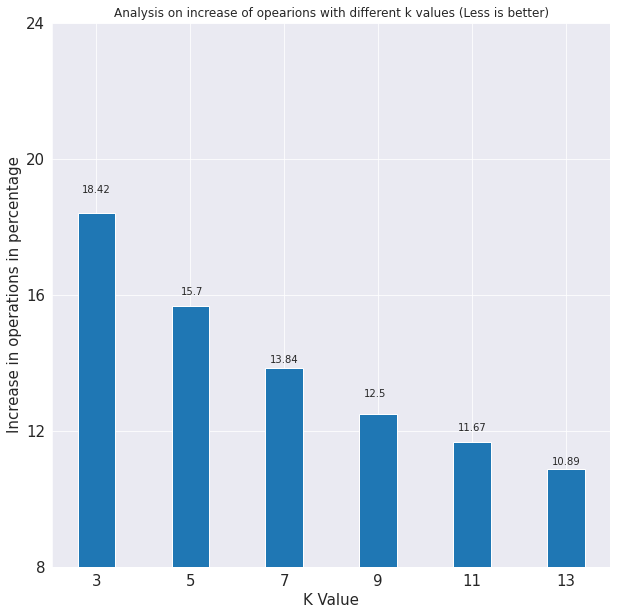

In [297]:
plt.figure(figsize=(10,10))
plt.bar([3,5,7,9,11,13],error)
plt.xticks([3,5,7,9,11,13],fontsize=15)
plt.ylim([8,24])
plt.yticks([8,12,16,20,24],fontsize=15)
plt.text(2.7,19,'18.42')
plt.text(4.8,16,'15.7')
plt.text(6.7,14,'13.84')
plt.text(8.7,13,'12.5')
plt.text(10.7,12,'11.67')
plt.text(12.7,11,'10.89')
plt.xlabel("K Value",fontsize=15)
plt.ylabel("Increase in operations in percentage",fontsize=15)
plt.title("Analysis on increase of opearions with different k values (Less is better)")
plt.savefig('kvalueerror.png')

In [240]:
reduction=100-reduction
reduction

array([1.66725121, 2.77333227, 3.8752021 , 4.97273969, 6.06582568,
       7.15436243])

In [266]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,10))
plt.bar([3,5,7,9,11,13],reduction)
plt.xticks([3,5,7,9,11,13],size=15)
plt.yticks([1,3,5,7,9],size=15)
plt.ylim([1,9])
plt.text(2.7,2,'1.67')
plt.text(4.7,3,'2.78')
plt.text(6.7,4,'3.88')
plt.text(8.7,5.2,'4.97')
plt.text(10.7,6.3,'6.07')
plt.text(12.7,7.3,'7.15')
plt.xlabel("K Value",fontsize=15)
plt.ylabel("Percentage of cells calculated",fontsize=15)
plt.title("Analysis on reduction of calculations with different k values (Less is better)")
plt.savefig('kvaluereduction.png')